In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import model_utils
from data_frame import getDataFrame
from torchvision.utils import make_grid
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
# First 100 catagories
train_df = getDataFrame()
train_df = train_df[:5850]

In [10]:
train_df['genus'].nunique()

22

In [3]:
BATCH = 32
EPOCHS = 10
LR = 0.002
IM_SIZE = 224

Transform = transforms.Compose(
    [
    transforms.ToTensor(),
    transforms.CenterCrop(666),
    transforms.Resize((IM_SIZE, IM_SIZE))
    ])

alter_img = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop(666),
    # transforms.ColorJitter(brightness=.5, hue=.3),
    transforms.RandomAffine(degrees=(0, 180), translate=(0.05, 0.1)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.Resize((IM_SIZE, IM_SIZE))
])

In [4]:
def split_indices(n, val_pct=0.25, seed=99):
    n_val = int(val_pct*n)
    np.random.seed(seed)
    idxs = np.random.permutation(n)
    return idxs[n_val:], idxs[:n_val]



In [5]:
X_Train, Y_Train = train_df['image_dir'].values, train_df['category'].values
train_indices, val_indices = split_indices(len(X_Train))


class GetData(Dataset):
    def __init__(self, FNames, Labels, Transform):
        self.fnames = FNames
        self.transform = Transform
        self.labels = Labels         
        
    def __len__(self):
        return len(self.fnames)

    # Returns the tensor image and corresponding label in a tuple
    def __getitem__(self, index):       
        #x = Image.open(self.fnames[index])
        img = cv2.imread(self.fnames[index])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.inRange(img, (165,155,115),(255,255,255))
        img[mask>0] = (0,0,0)
        
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Edge detection with sobel filters
        blur = cv2.GaussianBlur(gray, (3,3), 0)
        edge = cv2.Sobel(blur, cv2.CV_64F, 1, 1, ksize=5)
        mask = cv2.inRange(edge, (-1000000), (0))
        edge[mask>0] = 0
        mask2 = cv2.inRange(edge,(255), (1000000))
        edge[mask2>0] = 255
        edge = edge.astype(np.uint8)
        
        x = cv2.merge((img, edge, edge, edge))
        if "train" in self.fnames[index]:             
            return self.transform(x), self.labels[index]
        elif "test" in self.fnames[index]:            
            return self.transform(x), self.fnames[index]


                
trainset1 = GetData(X_Train[train_indices], Y_Train[train_indices], Transform)
trainset2 = GetData(X_Train[train_indices], Y_Train[train_indices], alter_img)
trainset3 = GetData(X_Train[train_indices], Y_Train[train_indices], alter_img)
trainset4 = GetData(X_Train[train_indices], Y_Train[train_indices], alter_img)

trainset = trainset1 + trainset2 + trainset3 + trainset4
valset = GetData(X_Train[val_indices], Y_Train[val_indices], Transform)

print(len(trainset) + len(valset))


19014


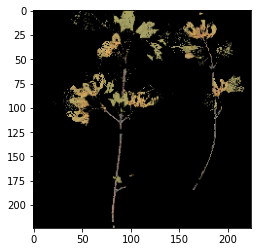

In [6]:
plt.imshow(trainset[0][0][:3,:,:].permute(1,2,0))

In [7]:
val_dl = DataLoader(valset, batch_size=BATCH, shuffle=True)
train_dl = DataLoader(trainset, batch_size=BATCH, shuffle=True)
print(len(val_dl), len(train_dl))
print(46*32+549*32)

46 549
19040


images.shape: torch.Size([32, 3, 224, 224])


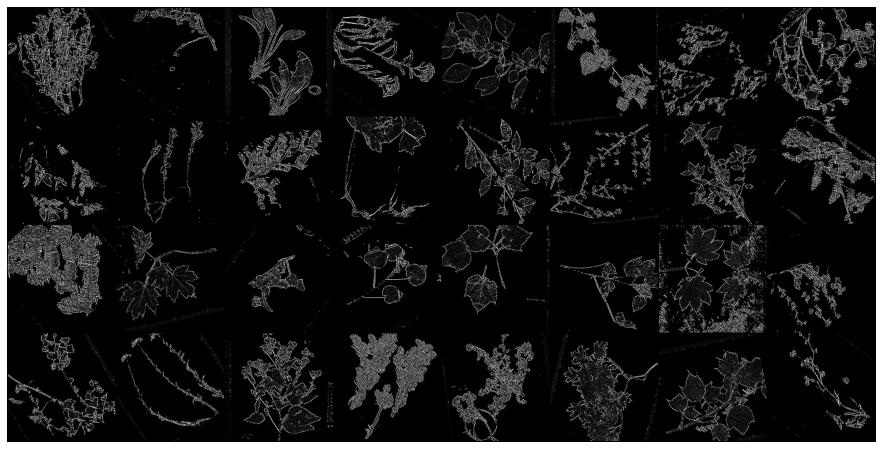

In [16]:
for images, _ in train_dl:
    images = images[:,3:,:,:]
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

In [9]:
class Essemble(nn.Module):
    def __init__(self, model1, model2):
        super(Essemble, self).__init__()
        self.model1 = model1
        self.model2 = model2
        self.classifier = nn.Sequential(nn.Linear(50, 101))
    
    def forward(self, x1, x2):
        x1 = self.model1(x1)
        x2 = self.model2(x2)
        x = torch.cat((x1,x2), dim=1)
        x = self.classifier(nn.functional.relu(x))
        return x
        

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# model 2
model_edge = torch.load('./edge_dense.pth')

n_inputs = model_edge.classifier.in_features

# model 1
model_img = torchvision.models.densenet169(pretrained=True)
model_img.classifier = nn.Linear(n_inputs, 101)

from os.path import exists
path_to_file = './processimg.pth'
file_exists = exists(path_to_file)
checkpoint = torch.load(path_to_file) if file_exists else None

if checkpoint:
    model_img.load_state_dict(checkpoint['state_dict'])
    print(f'model_img: Checkpoint has evaluation accuracy: {checkpoint["saved_accuracy"]}')

for param in model_edge.parameters():
    param.requires_grad = False

for param in model_img.parameters():
    param.requires_grad = False
    
model_edge.classifier = nn.Linear(n_inputs, 25)
model_img.classifier = nn.Linear(n_inputs, 25)

model_img: Checkpoint has evaluation accuracy: 0.6106101870536804


In [66]:
essemble = Essemble(model_img, model_edge)
criterion = nn.CrossEntropyLoss()

#not sure
optimizer = torch.optim.Adam(essemble)
essemble.to(device)

Essemble(
  (model1): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1

In [11]:
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}

from tqdm import tqdm

def train(trainloader, model, criterion, optimizer, scaler, exp_lr_scheduler, device=torch.device(device)):
    train_acc = 0.0
    train_loss = 0.0
    model.train()
    for images, labels in tqdm(train_dl):
        
        x1 = images[:,:3,:,:]
        x2 = images[:,3:,:,:]
        x1 = x1.to(device)
        x2 = x2.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast(enabled=True):
            output = model(x1,x2)
            loss = criterion(output, labels)
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        acc = ((output.argmax(dim=1) == labels).float().mean())
        train_acc += acc
        train_loss += loss
        del output
        del loss
        
    # Decay LR by a factor of 0.1 every 2 epochs
    exp_lr_scheduler.step()
    return train_acc/len(trainloader), train_loss/len(trainloader)

def evaluate(testloader, model, criterion, device=torch.device(device)):
    eval_acc = 0.0
    eval_loss = 0.0
    model.eval()
    for images, labels in tqdm(val_dl):
        x1 = images[:,:3,:,:]
        x2 = images[:,3:,:,:]
        x1 = x1.to(device)
        x2 = x2.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            output = model(x1, x2)
            loss = criterion(output, labels)

        acc = ((output.argmax(dim=1) == labels).float().mean())
        eval_acc += acc
        eval_loss += loss
        del output
        del loss
  
    return eval_acc/len(testloader), eval_loss/len(testloader)

In [14]:
essemble = torch.load('../essemble.pth')

for param in essemble.model1.parameters():
    param.requires_grad = True

for param in essemble.model2.parameters():
    param.requires_grad = True
    
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([
                                {'params': essemble.classifier.parameters()},
                                {'params': essemble.model1.parameters()},
                                {'params': essemble.model2.parameters()}
                            ])
essemble.to(device)

Essemble(
  (model1): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1

In [15]:
%%time
##%dirsrmal Training
scaler = torch.cuda.amp.GradScaler(enabled=True)
from torch.optim import lr_scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, 2, 0.1)

for epoch in range(EPOCHS):
    train_acc, train_loss = train(train_dl, essemble, criterion, optimizer, scaler, exp_lr_scheduler, device=device)
    eval_acc, eval_loss = evaluate(val_dl, essemble, criterion, device=device)
    torch.save(essemble, './essembleall.pth')
    print("")
    print(f"Epoch {epoch + 1} | Train Acc: {train_acc*100} | Train Loss: {train_loss}")
    print(f"\t Val Acc: {eval_acc*100} | Val Loss: {eval_loss}")
    print("===="*8)

100%|██████████| 46/46 [00:56<00:00,  1.22s/it]



Epoch 1 | Train Acc: 60.228824615478516 | Train Loss: 1.3122377395629883
	 Val Acc: 51.858943939208984 | Val Loss: 1.8804482221603394


100%|██████████| 46/46 [00:55<00:00,  1.21s/it]



Epoch 2 | Train Acc: 69.60382080078125 | Train Loss: 0.9766138792037964
	 Val Acc: 49.271244049072266 | Val Loss: 1.993756890296936


100%|██████████| 46/46 [00:55<00:00,  1.20s/it]



Epoch 3 | Train Acc: 85.7638931274414 | Train Loss: 0.4757407605648041
	 Val Acc: 62.90143585205078 | Val Loss: 1.3867367506027222


100%|██████████| 46/46 [00:56<00:00,  1.22s/it]



Epoch 4 | Train Acc: 91.3023681640625 | Train Loss: 0.3224303126335144
	 Val Acc: 63.90810775756836 | Val Loss: 1.4006962776184082


 43%|████▎     | 237/549 [15:20<20:11,  3.88s/it]


KeyboardInterrupt: 

In [59]:
for images, labels in val_dl:
    x1 = images[:,:3,:,:]
    x2 = images[:,3:,:,:]
    
    x1 = x1.to(device)
    x2 = x2.to(device)
    output = essemble(x1,x2)
    break

# images = images[output.argmax(dim=1) != labels].cpu()

# plt.figure(figsize=(16,8))
# plt.axis('off')
# plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
# images.shape